In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from torch.utils.data import DataLoader

from decode_fish.funcs.output_trafo import model_output_to_df
import ipyvolume as ipv

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

90.17 -45.58 30 ../fishcod/runs/ae1/dataloader.bs:1
90.88 -104.33 30 ../fishcod/runs/ae1/dataloader.bs:2
91.22 -15.38 30 ../fishcod/runs/ae1/dataloader.bs:4
89.96 -66.24 30 ../fishcod/runs/ae1/dataloader.bs:6


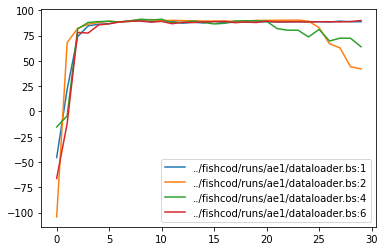

In [4]:
exps = sorted(glob.glob('../fishcod/runs/ae1/dataloader.bs*'))
# fig = plot_tb_logs(exps, 'SL Losses/gmm_loss', 1)
fig = plot_tb_logs(exps, 'Inp. Metrics/eff_3d', 1)

In [49]:
def eval_perf(model, img, gt, cuda=True, shift=True, px_size=np.array([100.,100.,300.])):
    
    model.eval().cuda() if cuda else model.eval().cpu()
    with torch.no_grad():
        res_dict = model(img[None].cuda()) if cuda else model(img[None])
    res_dict['xyzi_mu'] = res_dict['xyzi_mu']*0
    pred_df = model_output_to_df(res_dict, 0.1, px_size=px_size)
    free_mem()
    
    pred = pred_df
    if shift:
        perf_df, matches, shift = matching(gt_df, pred, print_res=True)
        pred = shift_df(pred, shift)
    perf_df, matches, _ = matching(gt_df, pred)
    return pred

In [5]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_1'
img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 200, 'cell3D', 'strong')
print(img.shape)

/groups/turaga/home/speisera/share_TUM/FishSIM/sim_1/mRNAlevel_200/cell3D/strong/w1_HelaKyoto_Gapdh_2597_p01_cy3__Cell_CP_14__cell3D__1.tif
torch.Size([1, 69, 318, 345])


In [7]:
gt_psf = load_tiff_image('/groups/turaga/home/speisera/share_TUM/FishSIM/PSF.tif')

In [43]:
cfg_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/test/test_sub/train.yaml'
cfg_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/simfish2/microscope.multipl:70/train.yaml'
cfg = OmegaConf.load(cfg_path)
model = hydra.utils.instantiate(cfg.model)
model = load_model_state(model, cfg.output.save_dir, 'model.pkl')
psf, noise, micro = load_psf_noise_micro(cfg)
psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))

<All keys matched successfully>

In [50]:
pred_df = eval_perf(model, img[:,:], gt_df, cuda=True, shift=True, px_size=np.array([100.,100.,300.]))
free_mem()

Recall: 1.000
Precision: 0.987
Jaccard: 98.745
RMSE_vol: 168.619
Eff_3d: 15.681
FN: 0.0 FP: 3.0
Shift: -47.88,-49.58,-148.73
Recall: 1.000
Precision: 0.987
Jaccard: 98.745
RMSE_vol: 25.158
Eff_3d: 87.359
FN: 0.0 FP: 3.0
Shift: -0.85,-0.00,-0.00


(array([24., 32., 45., 44., 29., 17., 20., 11.,  9.,  8.]),
 array([0.3348256 , 0.40127516, 0.46772474, 0.53417426, 0.60062385,
        0.6670734 , 0.73352295, 0.79997253, 0.8664221 , 0.93287164,
        0.9993212 ], dtype=float32),
 <BarContainer object of 10 artists>)

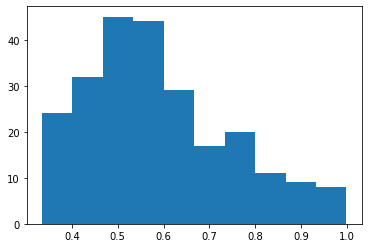

In [24]:
plt.hist(pred_df['int'])

tensor(12.9936, device='cuda:0')


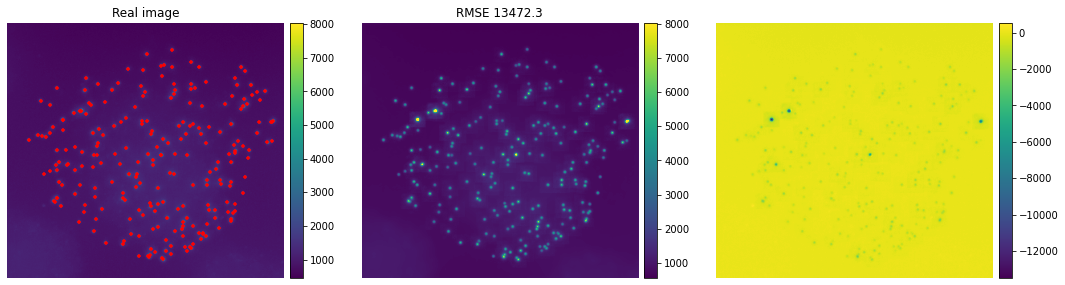

In [39]:
from decode_fish.funcs.output_trafo import *
with torch.no_grad():
    model.cuda()
    res_gt = model(img[None].cuda())
    locs_ae, x_os_ae, y_os_ae, z_os_ae, ints_ae, output_shape_ae = model_output_to_micro_input(res_gt, threshold=0.1)
    ae_img = micro(locs_ae, x_os_ae, y_os_ae, z_os_ae, ints_ae, output_shape_ae)
    print(ae_img.mean())
    pred_gt_df = model_output_to_df(res_gt, 0.1, px_size=np.array([100.,100.,300.]))
    free_mem()

    gt_fig = gt_plot(img, pred_gt_df, gt_df, np.array([100.,100.,300.]),ae_img[0]+res_gt['background'][0])
    plt.show()

tensor(12.9937, device='cuda:0')


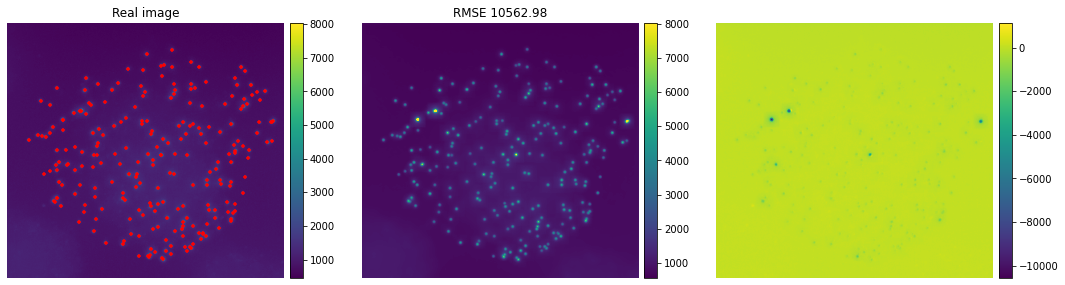

In [45]:
from decode_fish.funcs.output_trafo import *
with torch.no_grad():
    model.cuda()
    res_gt = model(img[None].cuda())
    locs_ae, x_os_ae, y_os_ae, z_os_ae, ints_ae, output_shape_ae = model_output_to_micro_input(res_gt, threshold=0.1)
    ae_img = micro(locs_ae, x_os_ae, y_os_ae, z_os_ae, ints_ae, output_shape_ae)
    print(ae_img.mean())
    pred_gt_df = model_output_to_df(res_gt, 0.1, px_size=np.array([100.,100.,300.]))
    free_mem()

    gt_fig = gt_plot(img, pred_gt_df, gt_df, np.array([100.,100.,300.]),ae_img[0]+res_gt['background'][0])
    plt.show()

In [59]:
pred = fq_nog_df
perf_df, matches, shift = matching(gt_df, pred, print_res=False)
# pred = shift_df(pred, shift)
# perf_df, matches, _ = matching(gt_df, pred)

In [26]:
psf_sl, _, _ = load_psf_noise_micro(cfg)
psf_sl.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf_init.pkl'))

psf_ae, _, _ = load_psf_noise_micro(cfg)
psf_ae.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))

<All keys matched successfully>

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

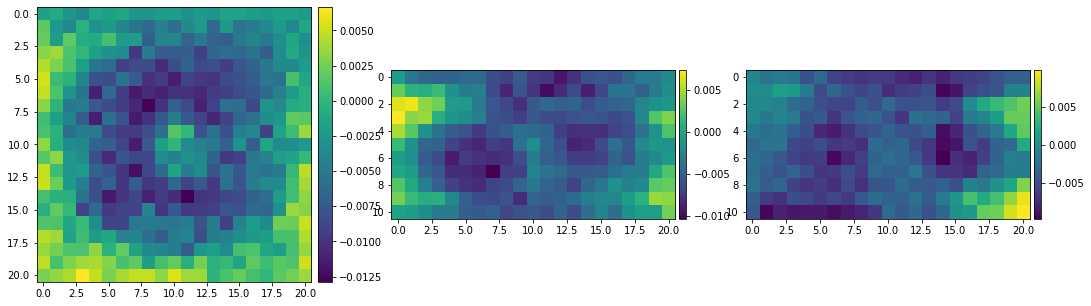

In [27]:
plot_3d_projections(psf_sl.psf_volume.detach().numpy()[0]-psf_ae.psf_volume.detach().numpy()[0])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

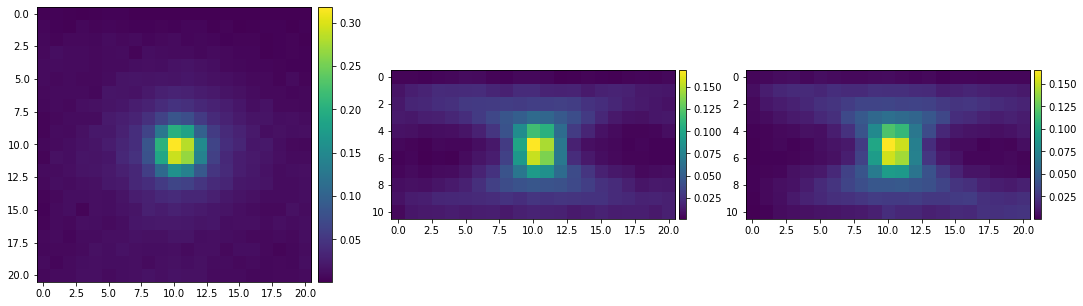

In [30]:
plot_3d_projections(psf_sl.psf_volume.detach().numpy()[0])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

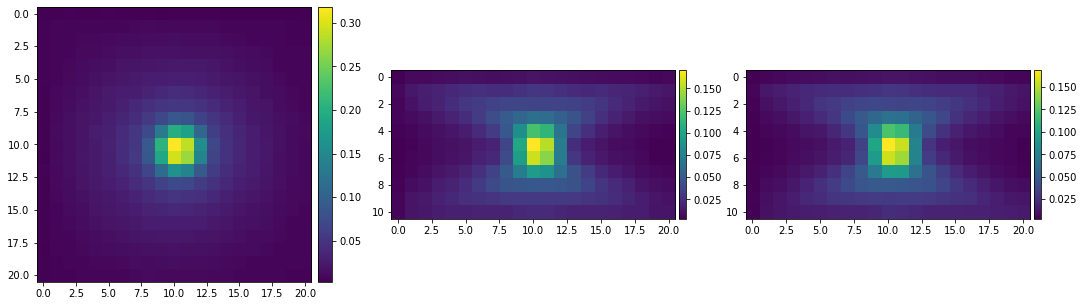

In [33]:
plot_3d_projections(psf_ae.psf_volume.detach().numpy()[0])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

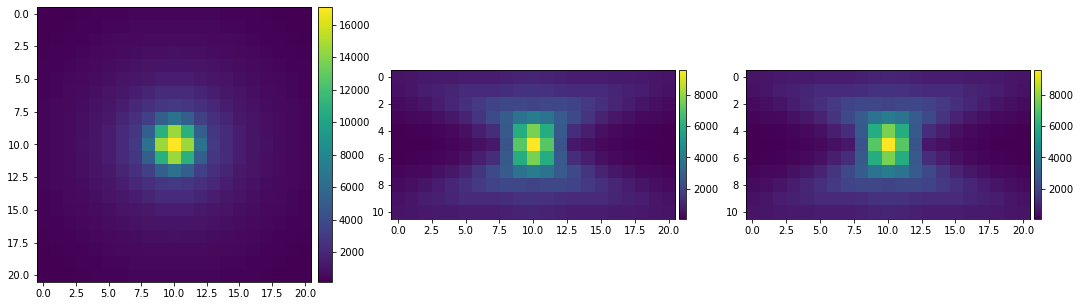

In [16]:
gt_psf = load_tiff_image('/groups/turaga/home/speisera/share_TUM/FishSIM/PSF.tif')
plot_3d_projections(gt_psf[0,::3,::3,::3])

In [54]:
def scatter3d_df(df, shape, px_size=[100,100,100], color='red'):
    ipv.scatter(df['x']/px_size[0] - 1/2*shape[2], 
                df['y']/px_size[1] - 1/2*shape[1], 
                df['z']/px_size[2] - 1/2*shape[0], size=1, marker='sphere', color=color)

In [60]:
vol = img.numpy()[0]
# gt_points = shift_locs(gt_df, vol.shape)
# fq_gmm_points = shift_locs(fq_gmm_df, vol.shape, np.array([100.,100.,300.]))
# fq_nog_points = shift_locs(fq_nog_df, vol.shape, np.array([100.,100.,300.]))
# pred_points = shift_locs(pred_df, vol.shape, np.array([100.,100.,300.]))

extent = [[-s/2,s/2] for s in vol.shape]
extent = [extent[i] for i in [2,1,0]]

ipv.figure()
ipv.pylab.volshow(vol, level=[.2,0.25,.1], opacity=[0.04,0.2,0.01], extent=extent)
# scatter3d_df(gt_df, vol.shape, [100.,100.,300.], 'black')
scatter3d_df(pred_df, vol.shape, [100.,100.,300.], 'red')
ipv.xyzlim(max(vol.shape)/2)
ipv.view(90, 40)
ipv.show()